In [1]:
import os
from symmer.symplectic.base import PauliwordOp
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import sys # Add path for pauli_to_mpo
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [3]:
from scratch import pauli_to_mpo as pm

In [4]:
test_dir = os.path.join(os.path.dirname(os.getcwd()), 'tests')
ham_data_dir = os.path.join(test_dir, 'hamiltonian_data')

In [5]:
filename = 'H4_STO-3G_SINGLET_JW.json'

if filename not in os.listdir(ham_data_dir):
    raise ValueError('unknown file')
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

## Generating MPO using the Pauli strings sequentially

In [6]:
# Exracting pstring data
pstrings, coefflist = zip(*data_dict['hamiltonian'].items())

coeffs = pm.coefflist_to_complex(coefflist)

print("Number of terms: {}".format(len(pstrings)))

print('Converting data dict')
for pstr, coeff in zip(pstrings[:5], coeffs[:5]):
    print(f"{pstr}: {coeff}")




Number of terms: 105
Converting data dict
IIIIIIII: (-1.0811399195666882+0j)
IIIIIIIZ: (0.013810914373994877+0j)
IIIIIIZI: (0.013810914373994856+0j)
IIIIIIZZ: (0.09424143717952153+0j)
IIIIIZII: (0.0375818021724733+0j)


Want to compare the output from the mpo generation with the exact matrix generated from PauliWordOp. 

Then will compare MPO generation including a truncation to a given bond dimension $D$. To measure the effect of the truncation we use the trace distance measure:

$$
\text{trace}((\rho - \sigma)^2)
$$

Preparing  exact mpo...
Contracting exact mpo...
Converting wordop to matrix...

Exact MPO construction equivalent to Matrix:  True
Trace distance for given bond dimension
    16: (15.866046789260023+0j)
    32: (2.222349305574701+0j)
    64: (1.9856804945739513e-13+0j)
    128: (2.6123087696407196e-14+0j)


/home/vinulw/.pyenv/versions/3.8.14/envs/env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


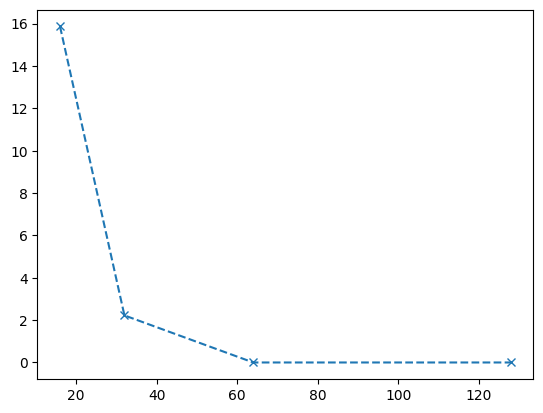

In [7]:
#    # Code to do the same conversion with Pauli WordOp
wordop = PauliwordOp.from_dictionary(data_dict['hamiltonian'])

print("Preparing  exact mpo...")
mpo = pm.pstrings_to_mpo(pstrings, coeffs, Dmax=None)

print("Contracting exact mpo...")
mpo_matrix = pm.contract_mpo(mpo)

print("Converting wordop to matrix...")
wordop_matrix = wordop.to_sparse_matrix.toarray()

print("")

print("Exact MPO construction equivalent to Matrix: ", np.allclose(mpo_matrix, wordop_matrix))

def trace_distance(m1, m2):
    return np.trace((m1 - m2) * np.conj((m1 - m2).T))

Dmaxs = [16, 32, 64, 128]

tdists = []
print("Trace distance for given bond dimension")
for D in Dmaxs:
    mpo = pm.pstrings_to_mpo(pstrings, coeffs, Dmax=D)
    mpo_matrix = pm.contract_mpo(mpo)
    tdists.append(trace_distance(wordop_matrix, mpo_matrix))
    print(f"    {D}: {tdists[-1]}")

plt.plot(Dmaxs, tdists, 'x--')
plt.show()


## Comparing approximate MPO groundstate to exact

In [8]:
from quimb.tensor.tensor_1d import MatrixProductOperator
from quimb.tensor.tensor_dmrg import DMRG2
from symmer.symplectic import QuantumState
from symmer.utils import exact_gs_energy

In [9]:
filtered_files = [   # all the 10 qubit files
    "B+_STO-3G_SINGLET_JW.json",
    "C_STO-3G_TRIPLET_BK.json",
    "C_STO-3G_TRIPLET_JW.json",
    "O_STO-3G_TRIPLET_JW.json",
    "Be_STO-3G_SINGLET_JW.json",
    "N_STO-3G_QUARTET_BK.json",
    "Li_STO-3G_DOUBLET_BK.json",
    "H2_6-31G_SINGLET_BK.json",
    "Be_STO-3G_SINGLET_BK.json",
    "HeH+_3-21G_SINGLET_BK.json",
    "H2_6-31G_SINGLET_JW.json",
    "N_STO-3G_QUARTET_JW.json",
    "B+_STO-3G_SINGLET_BK.json",
    "B_STO-3G_DOUBLET_BK.json",
    "H3+_STO-3G_SINGLET_JW.json",
    "Li_STO-3G_DOUBLET_JW.json",
    "H2_3-21G_SINGLET_BK.json",
    "H2_3-21G_SINGLET_JW.json",
    "H3+_STO-3G_SINGLET_BK.json",
    "B_STO-3G_DOUBLET_JW.json",
    "H4_STO-3G_SINGLET_JW.json",
    "HeH+_3-21G_SINGLET_JW.json",
    "H4_STO-3G_SINGLET_BK.json",
]

data_dicts = []

for f in filtered_files:
    with open(os.path.join(ham_data_dir, f), 'r') as infile:
        data_dicts.append(json.load(infile))


In [10]:
D = 128
for fl, dct in zip(tqdm(filtered_files), data_dicts):
    tqdm.write(f'Calculating properties for {fl}...')
    pstrings, coefflist = zip(*dct['hamiltonian'].items())
    coeffs = pm.coefflist_to_complex(coefflist)
    H_op = PauliwordOp.from_dictionary(dct['hamiltonian'])
    
    # Make MPO
    mpo = pm.pstrings_to_mpo(pstrings, coeffs, Dmax=D)
    mpo = [np.squeeze(m) for m in mpo]
    MPO = MatrixProductOperator(mpo, 'dulr')
    tqdm.write("   Generated MPO...")

    dmrg = DMRG2(MPO, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)
    dmrg.solve(verbosity=0, tol=1e-6)
    tqdm.write("   Found DMRG ground state...")

    dmrg_state = dmrg.state.to_dense()
    dmrg_state = QuantumState.from_array(dmrg_state).cleanup(zero_threshold=1e-5)

    gs_energy, gs_vec = exact_gs_energy(H_op.to_sparse_matrix)
    gs_state = QuantumState.from_array(gs_vec).cleanup(zero_threshold=1e-5)

    gs_overlap = np.linalg.norm(gs_state.dagger * dmrg_state)

    gs_energy = -1*np.linalg.norm(gs_state.dagger * H_op * gs_state)
    dmrg_energy = -1*np.linalg.norm(dmrg_state.dagger * H_op * dmrg_state)
    hf_energy = dct['data']['calculated_properties']['HF']['energy']

    tqdm.write(f"   GS Overlap: {gs_overlap}")
    tqdm.write(f"   GS Energy: {gs_energy}")
    tqdm.write(f"   HF Energy: {hf_energy}")
    tqdm.write(f"   DMRG Energy: {dmrg_energy}")
    tqdm.write("")


  0%|          | 0/23 [00:00<?, ?it/s]

Calculating properties for B+_STO-3G_SINGLET_JW.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.5044179693165021
   GS Energy: -24.189264917100495
   HF Energy: -23.948470366408024
   DMRG Energy: -24.18912681012846

Calculating properties for C_STO-3G_TRIPLET_BK.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.15122690545361858
   GS Energy: -37.21873355063724
   HF Energy: -37.198392563731566
   DMRG Energy: -37.21866842668871

Calculating properties for C_STO-3G_TRIPLET_JW.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.30558582047983324
   GS Energy: -37.21873355063673
   HF Energy: -37.198392563731566
   DMRG Energy: -37.21769906438331

Calculating properties for O_STO-3G_TRIPLET_JW.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.1526406687947302
   GS Energy: -73.80415023325793
   HF Energy: -73.80415023325587
   DMRG Energy: -73.80332920355002

Calculating properties for Be

# Profiling performance with $D$

Ran the above parameter sweep for various values of `D = [16, 32, 64, 128]` to check its performance. Saved output for all molecules in `scratch/231122120017_profiling_D_squential_MPO.csv`. Analysis of this data follows below

In [21]:
import pandas as pd

scratch_dir = os.path.join(os.path.dirname(os.getcwd()), 'scratch')

df = pd.read_csv(os.path.join(scratch_dir, '231122120017_profiling_D_squential_MPO.csv'))

In [22]:
df

,File,D,GS Overlap,GS Energy,HF Energy,DMRG2 Energy
0,B+_STO-3G_SINGLET_JW.json,16,0.000000,-24.189265,-23.948470,-16.558916
1,C_STO-3G_TRIPLET_BK.json,16,0.000000,-37.218734,-37.198393,-36.262193
2,C_STO-3G_TRIPLET_JW.json,16,0.000000,-37.218734,-37.198393,-36.730572
3,O_STO-3G_TRIPLET_JW.json,16,0.000000,-73.804150,-73.804150,-72.478715
4,Be_STO-3G_SINGLET_JW.json,16,0.000000,-14.403655,-14.351880,-13.348199
...,...,...,...,...,...,...
87,H3+_STO-3G_SINGLET_BK.json,128,1.000000,-1.360999,-1.246342,-1.360999
88,B_STO-3G_DOUBLET_JW.json,128,0.464595,-24.189265,-24.148989,-24.188968
89,H4_STO-3G_SINGLET_JW.json,128,0.999843,-1.874302,-1.333350,-1.874300
90,HeH+_3-21G_SINGLET_JW.json,128,0.501455,-3.172817,-2.887438,-3.143570


In [23]:
for col in df.columns:
    print(col)

File
D
GS Overlap
GS Energy
HF Energy
DMRG2 Energy


In [31]:
data = df.iloc[:, 1:6]
data

,D,GS Overlap,GS Energy,HF Energy,DMRG2 Energy
0,16,0.000000,-24.189265,-23.948470,-16.558916
1,16,0.000000,-37.218734,-37.198393,-36.262193
2,16,0.000000,-37.218734,-37.198393,-36.730572
3,16,0.000000,-73.804150,-73.804150,-72.478715
4,16,0.000000,-14.403655,-14.351880,-13.348199
...,...,...,...,...,...
87,128,1.000000,-1.360999,-1.246342,-1.360999
88,128,0.464595,-24.189265,-24.148989,-24.188968
89,128,0.999843,-1.874302,-1.333350,-1.874300
90,128,0.501455,-3.172817,-2.887438,-3.143570


In [35]:
data['HF delta'] = (data['HF Energy'] - data['GS Energy'])/data['GS Energy']
data['DMRG delta'] = (data['DMRG2 Energy'] - data['GS Energy'])/data['GS Energy']

In [36]:
data

,D,GS Overlap,GS Energy,HF Energy,DMRG2 Energy,HF delta,DMRG delta
0,16,0.000000,-24.189265,-23.948470,-16.558916,-9.954604e-03,-3.154436e-01
1,16,0.000000,-37.218734,-37.198393,-36.262193,-5.465255e-04,-2.570050e-02
2,16,0.000000,-37.218734,-37.198393,-36.730572,-5.465255e-04,-1.311602e-02
3,16,0.000000,-73.804150,-73.804150,-72.478715,-2.791949e-14,-1.795882e-02
4,16,0.000000,-14.403655,-14.351880,-13.348199,-3.594548e-03,-7.327698e-02
...,...,...,...,...,...,...,...
87,128,1.000000,-1.360999,-1.246342,-1.360999,-8.424459e-02,9.511545e-14
88,128,0.464595,-24.189265,-24.148989,-24.188968,-1.665049e-03,-1.227315e-05
89,128,0.999843,-1.874302,-1.333350,-1.874300,-2.886153e-01,-8.320246e-07
90,128,0.501455,-3.172817,-2.887438,-3.143570,-8.994505e-02,-9.218106e-03


In [39]:
grouped_data = data.iloc[:, [0, 1, 5, 6]].groupby(['D']).mean()
grouped_data

,GS Overlap,HF delta,DMRG delta
D,,,
16,0.104675,-0.045416,-0.227108
32,0.114084,-0.045416,-0.094577
64,0.442574,-0.045416,-0.006999
128,0.557189,-0.045416,-0.004995


<AxesSubplot: title={'center': 'Bond dimension impact on GS overlap'}, xlabel='D'>

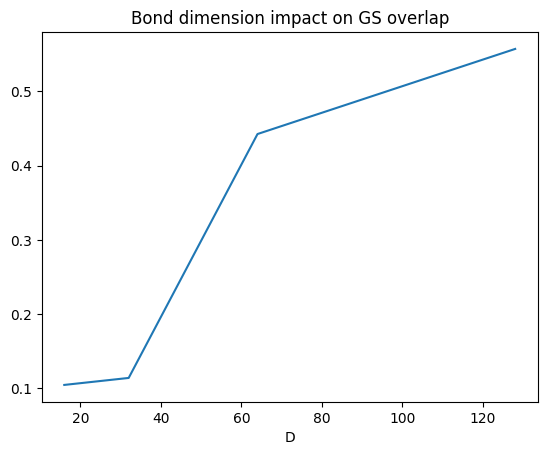

In [45]:
grouped_data['GS Overlap'].plot(title='Bond dimension impact on GS overlap')


<AxesSubplot: title={'center': 'Difference from GS Energy for DMRG and HF'}, xlabel='D'>

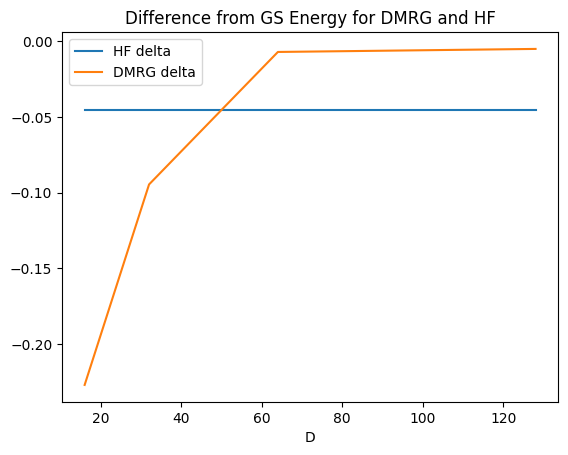

In [46]:
grouped_data['HF delta'].plot(legend=True, title='Difference from GS Energy for DMRG and HF')
grouped_data['DMRG delta'].plot(legend=True)